# 🍀 NLP Going Deeper Project : SentencePiece 써먹기! 🍀

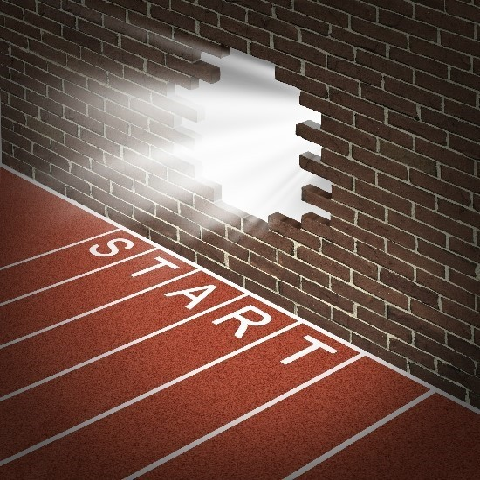

## ⏫ 들어가며 ⏫

드디어 **Going Deeper**입니다! 😄😄

Going Deeper라서 이전의 Exploration보다 어렵고 깊은 부분이 많을 수 있습니다.

하지만 최대한 이해한 선에서 한 번 열심히 이야기를 진행해보도록 하겠습니다!

그러면, 시작해 보겠습니다.

***

## Step 0. 프로젝트를 위한 담금질

우선, 이번 프로젝트 노드를 수행하기 위해서는 살펴보아야 할 데이터가 있습니다.

이에, 원활한 프로젝트 진행을 위해 이번 스텝에서는 프로젝트를 수행하기 위한 연습을 해보겠습니다.

이번에 배우는 것은 문장을 조각내는 방법입니다. 어떤 문장을 일정한 기준을 갖는 단어로 쪼개는 것을 말하는데, 퍼즐 맞추기로 예를 들면, 너무 지나치게 잘게 쪼개면 넓은 그림을 담는 것이 힘들다 보니 다시 맞추는 것이 어려울 것이고, 너무 크게 쪼갰다간 퍼즐이 너무 쉬워지게 됩니다.

이번 코스에선 문장 데이터를 직접 토큰화하며 어떤 방법이 가장 적합한 단어 조각을 만들어 내는지 실습해보도록 하겠습니다.

이번 노드에서는 **KoNLPy**, 그 중에서도 가장 성능이 괜찮은 **MeCab 클래스**를 활용하고 있습니다.

저는 AIFFEL 클라우드에서 작업하여 아래 명령어를 입력해줌으로서 설치 여부를 확인하였습니다.

- **$ sudo apt-get install g++ openjdk-8-jdk**

- **$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)**

- **$ pip install konlpy**

위 과정을 거친 다음, 다운받은 mecab을 import 하면 형태소 분석을 할 수 있습니다. 이렇게 말이죠. 😎

In [1]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('하루종일네생각에숨이멎을것같아'))

['하루', '종일', '네', '생각', '에', '숨', '이', '멎', '을', '것', '같', '아']


**이제, 본격적으로 시작해 보겠습니다! ⭐⭐**

아래의 라이브러리들을 import 해주겠습니다.

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

학습 환경을 구성하고 데이터를 내려받습니다.

아래 데이터는 **한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터**입니다. 이번에 사용할 데이터는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다!

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


기타 다른 종류의 데이터들은 여기에서 확인할 수 있을 것입니다.

**링크 : https://github.com/jungyeul/korean-parallel-corpora**

데이터를 내려받았으니 이제 손을 좀 봐야 할 것 같네요. 😄😄

최소한의 Essential한 분석으로 데이터가 얼마나 있고, 어떻게 생겼는지 정도를 확인해 보도록 합니다.

데이터 사이즈는 94123 즉, 94123개의 문장 데이터가 있습니다. 우리는 각 문장의 길이를 확인해 보려고 합니다.

이 과정은 지나치게 긴 데이터를 삭제하거나, 지나치게 짧은 데이터를 검증할 수 있게 해줍니다! 😎 

아래는 **문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 나타내 줍니다.**

여기서 raw 변수는 이전 스텝에서 내려받은 데이터가 담긴 변수입니다.

문장의 최단 길이는 1 입니다.
문장의 최장 길이는 377 입니다.
문장의 평균 길이는 60 입니다.


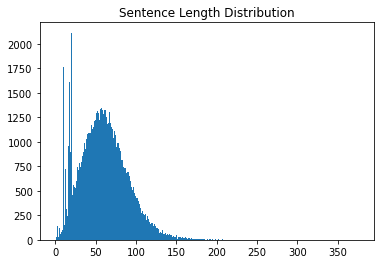

In [4]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이는", min_len, '입니다.')
print("문장의 최장 길이는", max_len, '입니다.')
print("문장의 평균 길이는", sum_len // len(raw), '입니다.')

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

**우리는 이쯤에서 다음과 같은 생각을 해볼 수 있을 것입니다!🧡**

- 길이가 1인 문장은 어떻게 생겼을까?
- 분포상에서 급격히 솟아오른 구간은 무엇을 의미할까? 유의미한 데이터가 존재할까?
- 어디서부터 어디까지 잘라야 할까?

첫 번째로 **길이가 1인 문장은 어떻게 생겼을지** 살펴봅니다.

In [5]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


출력해 보니, 따옴표 형태의 문자가 나왔습니다.

자연어 처리에서는 보통 이러한 문자들은 **의미를 가지지 않는 노이즈 데이터로 봅니다.**

왠지 길이별로 확인할 일이 많을 것 같아 위에서 함수(check_sentence_with_length)를 미리 정의해 두었는데, 좀 더 확인을 해봐야 할 듯 합니다. 😂😂

**이상치(Outlier)** 가 될 수 있는 문장의 길이를 살펴봅니다.

In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index :", idx+1)

Outlier Index : 11
Outlier Index : 19
Outlier Index : 21


**index가 11인 데이터에 대한 문제를 확인해 보겠습니다.**

- 확인 결과, 중복 데이터가 뚜렷하게 나타났습니다.

In [7]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

**다음으로 index가 19인 데이터의 문제를 확인해 보겠습니다.**

- 확인 결과, 문장의 첫 번째 글자가 특수문자나 숫자로 구성된 문장들이 뚜렷하게 나타났습니다.

In [8]:
check_sentence_with_length(raw, 19)

성공할 수 있는 일들이 있습니다."
두번째 목적은 상품을 파는 것이다.
그것들은 무엇을 하기 위한 것인가?
- 어째서 그렇게 대단한 것입니까?
불매운동가들의 시선을 끌고 싶은가?
그리고 우리는 계속해서 외식을 하며
(나는 그가 정직하다고 생각한다.)
박스데일도 동일한 기법을 사용한다.
"우리는 전속력으로 달려야 합니다.
수익은 연 25%씩 늘어나고 있다.
미국인 반체제 인사 해리 우의 운명
국가를 위해 좋은 일이 될 것이라고
무역 적자는 무역 흑자로 돌아섰으며
경찰에서조차 수사를 벌이고 있습니다
다음 번이 3월1일로 예정되어있다.
우리는 허구적인 시대에 살고 있다.
모 아니면 도였지요’’라고 말했다.
이씨는 짧았던 결혼을 세 번 했다.
하지만 성인이 되려면 아직 멀었다.
양국은 상호 3위의 교역상대국이다.
어떻게 지속적인 동기부여를 받느냐?
편지는 의사소통 이상의 일을 한다.
식량 부족으로 고통받는 북한 주민들
그는 뉴욕 금융지구에 살고 있었다.
6. “교회에 열심히 나가는가요?”
신문사가 발견된 기밀문서를 받았다.
3.인맥을 두루 갖춰놓지 못하는 것
15.면접 질문에 집중하지 않는 것
20.월급 이야기를 일찍 꺼내는 것
디아즈는 진지해지려고 하지 않는다.
전갈은 월마트 직원에 의해 잡혔다.
4.여성은 증상을 스스로 진단한다.
당시 휴스는 "나는 다스 베이더다!
회사에 대해 약간의 조사를 한다.:
스폰지에 물을 묻혀 청소해도 된다.
그러나 이를 뒷받침할 증거는 없다.
그는 올해 가을 손자를 보게 된다.
린은 칼을 이용해 쓰레기를 뒤진다.
거주지가 소아과 병원 인근일 경우.
언제든 메모해 두고 가지고 다닌다.
대법원의 심리는 6일부터 시작됐다.
* 원하는 가격에 흥정을 하는 방법
그는 치료 중이던 26일 사망했다.
무샤라프 대통령은 참석하지 않았다.
이미 경영진 2500명이 해임됐다.
스피처는 3명의 자녀를 두고 있다.
이들은 보통 10일 내로 사망한다.
그는 “왜 대통령이 되려 하느냐?”
* 뗏목, 카누등을 타고 구경할 때
유대인연합은 법원 결정을 환영했다.


**마지막으로 index가 21인 데이터의 문제를 확인해 봅니다.**

- 확인 결과, 아까 전 index가 19인 데이터의 문제와 비교적 동일한 문제로 확인됩니다.

In [9]:
check_sentence_with_length(raw, 21)

미국과 영국의 과학자들이 악수를 했다.
인력은 기계에 의해 보강되어야만 했다.
"시장은 그들에게 넓게 열려 있습니다.
아디다스는 또 다른 이점도 갖고 있다.
공부를 위해서만 이용하겠다고 말입니다.
환경법규의 도입은 고통스러운 과정이다.
- 여보, 이쪽이야, 아니면 저쪽이야?
인도는 훨씬 늦게 게임에 뛰어 들었다.
요즘 대부분의 기업들이 그렇지 않은가?
카리스마적인 지도자들은 위험을 즐긴다.
우리가 하려고 하는 일의 모델은 없다.
정상 회담은 오늘 늦게 끝날 것입니다.
그리고 공화당의 추정은 절반만 맞았다.
하지만 증가하고 있는 노인 인구수에따라
민간부문에서 그런 일을 할 수는 없다고
금년초 이라크 정보부는 "사담 후세인:
실제로 이 방법은 만족스럽지가 못하다.
카자흐스탄으로부터 중국으로 입국하려다가
클립퍼 칩에 대한 이야기로 들어 가자.
북한의 무기 개발에 대한 CIA 보고서
어려움을 겪고 있는 멕시코 경제에 대한
그는 ''미국은 우리의 최악의 적이다.
수로가 오염되고 야생동물이 밀렵되었다.
이런 지역들을 보살피고 보호해야 한다.
학습 방법은 훨씬 더 흠칫한 것입니다.
포옹은 심장에 좋은 약 일 수 도 있다
(경찰은 심문을 위해 그를 구금했다.)
금년에는 이 숫자가 58%로 증가했다.
(금고를 뒤져 많은 서류를 가져갔다.)
김치는 열량은 적고 비타민은 풍부하다.
smear campaign (흑색선전)
아들은 아버지로부터 사업을 이어받는다.
그것은 한계 효과가 나타나는 시기이다.
"사람들에게 선택권이 주어져야 합니다.
로야 저가는 임시 의사 결정 집단이다.
160석이 여성 대표들에게 보장되었다.
걷기 용으로 고안된 신발이 가장 좋다.
이것을 일주일에 5번 정도 해야 한다.
해외 판권은 이미 16개국에서 팔렸다.
그리고 나는 이렇게 엄숙히 서약합니다:
하지만 오늘의 주제를 그는 알것입니다:
(그 사건들은 전쟁 발발로 발전했다.)
"그는 정말로 국민들을 실망시켰습니다.
"제국의 반격"과 새 영화 "스타워즈:
남북간 해상 교전으로 남한 경비정 침몰
공룡들은 필연적으로

**중복을 제거할 때, Python의 기본 자료형 set을 활용하게 됩니다.**

set은 집합을 정의하는 자료형으로, **중복을 허용하지 않는다는 것**이 가장 큰 특징입니다! 😍

고맙게도 set는 변환하는 과정에서 자동으로 중복된 요소를 제거해 준다는 점에서 편리하다고 할 수 있습니다.

**단, list의 순서가 엉키게 될 수 있으니 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의**가 필요합니다. 😭

중복을 제거했다면, 이제 다시 한 번 분포 코드를 돌려서 생존한 데이터의 수를 확인해 보겠습니다.

Data Size: 77591
생존한 문장의 최단 길이는 1 입니다.
생존한 문장의 최장 길이는 377 입니다.
생존한 문장의 평균 길이는 64 입니다.


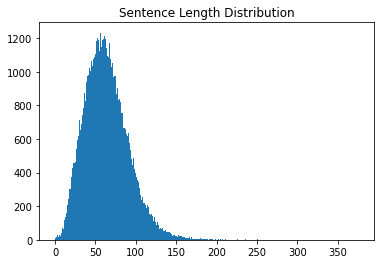

In [10]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("생존한 문장의 최단 길이는", min_len, '입니다.')
print("생존한 문장의 최장 길이는", max_len, '입니다.')
print("생존한 문장의 평균 길이는", sum_len // len(cleaned_corpus), '입니다.')

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

출력된 분포는 이전의 분포보다 더욱 깔끔한 형태의 분포가 됐습니다!

그런데 **자연어 처리에서 모델 학습의 효율을 생각했을 때, 모든 데이터를 다 사용하는 것은 연산량을 높여 학습 효율을 저하시킬 수 있어서 매우 비효율적인 방법입니다.**

그런데 각 데이터의 크기가 모두 동일해야 하는 미니배치의 특징 때문에, 가장 긴 데이터를 기준으로 Padding을 하게 됩니다.

결국 모든 데이터를 다 사용하게 될 경우, 일부만 사용했을 때보다 학습에 더 많은 메모리를 소모할 수밖에 없게 될 것입니다.

길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 다른 방법을 쓰겠습니다.

아까 전에 우리는 지나치게 긴 문장이나 짧은 문장을 처리하는 데 초점을 맞추고 있었습니다.

**조금 더 효율적인 학습을 위해서 너무 긴 문장이나 너무 짧은 문장을 제거하는 전처리를 해 주겠습니다!**

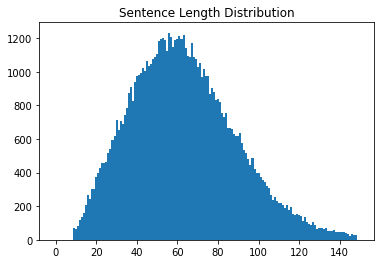

In [11]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

지금까지 라이브러리를 불러오고 데이터를 다운받아 살펴보고 전처리 등의 분석을 수행해 보았습니다.

다음은 **토큰화**를 수행해 보겠습니다!

첫 번째로 **공백 기반 토큰화**입니다. 우선 아래의 작업을 수행합니다.

- tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻습니다.
- 정제된 데이터를 공백 기반으로 토큰화하여 list에 저장합니다.
- 얻은 단어 사전의 크기를 확인합니다.

In [12]:
## tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻습니다.

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
## 정제된 데이터를 공백 기반으로 토큰화하여 list에 저장합니다.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [14]:
## 공백 기반 토큰화를 수행하고 얻은 단어 사전의 길이를 확인합니다.
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size :", len(split_tokenizer.index_word))

Split Vocab Size : 237435


생성된 단어 사전은 아래와 같이 구성됩니다.

**23만 개가 넘는 단어가 담긴 사전을 한 번에 다 열 수는 없고..^^ 20개만 확인해 보도록 할게요.**

- **주의사항** : idx는 0부터 시작하며, for 반복문으로 얻어진 idx 값이 18을 넘어선 19가 되어야 20개의 데이터가 나오므로, idx > 18 이어야 합니다.

In [15]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 18: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번
12 : 한
13 : 대해
14 : 것으로
15 : 전
16 : 것이라고
17 : 미국
18 : 있다고
19 : 것을


동사로 이루어진 단어를 살피면 공백 기반 토큰화의 문제점을 확인할 수 있습니다.

index 1의 단어인 '밝혔다.' 는 '밝히다', '밝다' 등과 유사한 의미를 지니고 있음에도 전혀 다른 단어로 분류될 수 있습니다.

사실 더 돌려볼 수 있을 테지만, 시간이 오래 걸릴 것 같으니까 일단은 23만 개가 넘는 단어가 속해있으니 직관적으로 이해하고 넘어갑시다!

이처럼 **공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량을 증가시켜 학습 속도를 저하시키는 원인이 됩니다.**

만일 다른 예시로, 뽑 + 혔다 라고 토큰화했다면 어땠을까요? 뽑 + 히다, 뽑 + 다 같은 구절이 등장했을 때, 공통된 어절인 뽑 은 하나로 묶여 학습 중에 의미를 파악하기가 수월해지겠죠? 동시에 단어 사전도 효율적으로 축소될 것입니다.

바로 이어서 형태소 분석기를 활용한 형태소 기반 토큰화를 살펴보도록 하겠습니다! 💎💎

한국어 형태소 분석기의 대표적인 예로 Khaiii와 KoNLPy를 들 수 있습니다.

우리는 Step 0 시작 초반에 언급했던 **KoNLPy의 Mecab 클래스를 활용**하여 노드를 진행하고 있으므로, 이를 활용하겠습니다.

이번에도 동일한 방법으로 단어 사전과 Tensor 데이터를 얻습니다.

In [16]:
# mecab.morphs()를 사용하여 형태소 분석을 할 수 있습니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

**형태소 기반의 토큰화를 진행한 후의 단어 사전의 크기를 살펴보겠습니다.**

- 확인 결과, 공백 기반 토큰화에 비하여 단어 사전의 크기가 크게 줄어들었습니다.
- 이로 인해, 학습량에 있어서는 공백 기반 토큰화보다 형태소 기반 토큰화가 더 우월해 보입니다!

In [17]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size :", len(mecab_tokenizer.index_word))

MeCab Vocab Size : 52279


여기까지의 과정은 Encoding입니다. Encoding이 있으면 Decoding도 필요하겠죠?

**아래는 Decoding을 수행하는 방법입니다. 총 2가지 방법이 있습니다.**

- tokenizer.sequences_to_texts() 함수를 사용
- tokenizer.index_word 를 사용

In [18]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

이 사건 으로 하산 우딘 을 비롯 , 2 명 의 용의자 는 유죄 가 밝혀 지 면 사형 에 처해질 것 이 다 .


In [19]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

이 사건 으로 하산 우딘 을 비롯 , 2 명 의 용의자 는 유죄 가 밝혀 지 면 사형 에 처해질 것 이 다 . 


## Step 1. SentencePiece 설치

이제 Step 0에서 살펴본 내용을 바탕으로 SentencePiece를 활용하는 프로젝트를 진행합니다.

SentencePiece에 대한 내용을 아래의 링크를 통해 살펴보도록 하겠습니다. 아래 링크의 후반부 구글 SentencePiece 관련 내용을 읽어보면 됩니다.

**링크 : https://blog.naver.com/hellopangx2/222497485852**

그 외, 더 참고할 만한 링크도 추가로 첨부해두겠습니다.

**추가 링크1 : https://mangastorytelling.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-%EC%9E%85%EB%AC%B8-1402-%EC%84%BC%ED%85%90%ED%8A%B8%ED%94%BC%EC%8A%A4SentencePiece**

**추가 링크2 : https://paul-hyun.github.io/vocab-with-sentencepiece/**

**SentencePiece 모델의 장점을 잠깐 소개하고 넘어가겠습니다.**

- Corpus 데이터로부터 쉽게 추출해서 생성할 수 있습니다.
- Subword 기반이기 때문에 새롭게 생성되는 단어에 대한 OOV(Out-of-Vocabulary) 문제에 대해서도 robust하게 대처할 수 있습니다.
- 언어에 중립적이기 때문에 여러 언어가 섞여 있는 텍스트를 처리하는 데에도 좋습니다.

또한 SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근의 pretrained model들이 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준적으로 많이 사용되고 있는 모델입니다.

이제 **SentencePiece 설치를 진행합니다. 아래 명령어를 Cloud Shell에 입력해주면 쉽게 설치하실 수 있습니다.**

- pip install sentencepiece

## Step 2. SentencePiece 모델 학습

앞서 공백 기반 토큰화 부분에서 함수로 정의한 tokenize() 코드를 다시 한 번 확인해 보겠습니다.

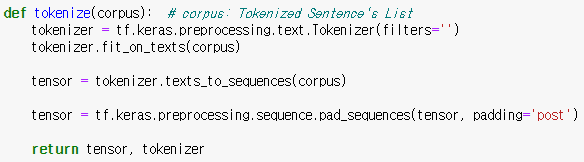

tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 순차적으로 수행시킵니다.

그러면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 줍니다.

**참고 - padding='post'는 무엇을 의미할까요? : https://blog.naver.com/qbxlvnf11/221945962124**

이를 위해서 **SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.** 모델을 학습시켜 보겠습니다.

모델 학습이 정상적으로 완료되면, korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 개인 작업 디렉토리에 잘 생성되었을 것입니다.

In [20]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Oct  3 13:30 korean_spm.model
-rw-r--r-- 1 root root 146388 Oct  3 13:30 korean_spm.vocab


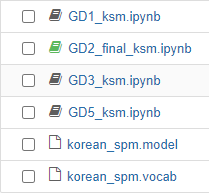

이제 학습된 SentencePiece 모델의 활용을 보도록 하겠습니다.

In [21]:
## 예시 1.

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('내생애이처럼아름다운날또다시올수있을까요')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('내생애이처럼아름다운날또다시올수있을까요',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[131, 663, 1450, 8, 742, 98, 1947, 38, 112, 777, 7198, 4597, 1677, 91, 2129, 5, 7024]
['▁내', '생', '애', '이', '처럼', '아', '름', '다', '운', '날', '또', '다시', '올', '수', '있', '을', '까요']
내생애이처럼아름다운날또다시올수있을까요


In [22]:
## 예시 2.

s2 = spm.SentencePieceProcessor()
s2.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s2.EncodeAsIds('오징어게임은잔혹하지만재미있다')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s2.SampleEncodeAsPieces('오징어게임은잔혹하지만재미있다',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s2.DecodeIds(tokensIDs))

[224, 2708, 73, 82, 516, 12, 3415, 2417, 2007, 446, 136, 1296]
['▁오', '징', '어', '게', '임', '은', '잔', '혹', '하지만', '재', '미', '있다']
오징어게임은잔혹하지만재미있다


위의 두 예시를 들었습니다. 대체로 공백 기반 토큰화보다는 더 세밀하게 토크나이징이 되었습니다! 😍😍

물론 숫자 벡터는 🥕🥕~ 덤이죠!

## Step 3. Tokenizer 함수 작성

이제 우리는 다른 데이터에도 원활하게 모델을 적용할 수 있도록, **위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의합니다.**

하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다.

최대한 SentencePiece 모델과 가깝게 정의하기 위해 아래 조건을 만족하도록 설계합니다.

- 매개변수로 토큰화된 문장의 list를 전달하는 대신, 온전한 문장의 list를 전달
- 생성된 vocab 파일을 읽어와 {word : idx} 형태를 가지는 word_index 사전과 {idx : word} 딕셔너리 형태를 가지는 index_word 사전을 생성하고 함께 반환
- Return 값인 tensor는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장
- 바로 학습에 사용할 수 있도록 사전에 Padding

In [23]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

직접 위 함수를 사용한 예시를 살펴보도록 하겠습니다.

In [24]:
## sp_tokenize(s, corpus) 예시 1. AIFFEL 노드의 예시

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


In [25]:
## sp_tokenize(s, corpus) 예시 2. 아이유, '아이와 나의 바다' 가사 중 일부

my_corpus2 = ['또다시 헤매일지라도', '돌아오는 길을 알아']
tensor2, word_index, index_word = sp_tokenize(s, my_corpus2)
print(tensor2)

[[ 159 4597 1130  965   21   29 3392]
 [4884   10 1243    5 3241    0    0]]


## Deep Dive : 네이버 영화리뷰 감정분석 Task에 적용하기

**이전 Exploration 7에서 다룬 네이버 영화리뷰 감정분석 Task에 SentencePiece 모델을 적용해볼 수 있을까요?**

Exploration 7에서는 KoNLPy에서 제공하는 형태소 분석기를 주로 사용했었습니다.

그 때는 세 가지 서로 다른 모델(1-D CNN, LSTM, GlobalMaxPooling1D)을 학습시켜서 정확도 85%에 도전했었던 기억이 있을 겁니다. ㅎㅎ

이번에는 앞에서 살펴본 SentencePiece 모델을 주로 사용하게 됩니다.

과연 SentencePiece 모델은 KoNLPy의 형태소 분석기의 성능을 넘을 수 있을까요?

### 1. 라이브러리 불러오기

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from konlpy.tag import Mecab
import sentencepiece as spm
from tensorflow import keras

%matplotlib inline

### 2. 네이버 영화리뷰 데이터 가져와 살펴보기

지난 Exploration 7에서 활용했던 네이버 영화리뷰 데이터를 가져와 다시 한 번 살펴보겠습니다.

In [27]:
train_data = pd.read_table('~/aiffel/aiffel_project_ksm/Going-Deeper/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_project_ksm/Going-Deeper/ratings_test.txt')
display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


학습 데이터와 테스트 데이터의 개수는 다음과 같습니다.

In [28]:
## 학습 데이터의 개수
print("학습 데이터는",len(train_data), '개 있어요!')

## 테스트 데이터의 개수
print("테스트 데이터는",len(test_data), '개 있어요!')

학습 데이터는 150000 개 있어요!
테스트 데이터는 50000 개 있어요!


**중복을 제외한** 학습 데이터와 테스트 데이터의 개수는 다음과 같습니다.

여기서 우리는 **document 컬럼**에 초점을 맞추었는데, 그 이유는 SentencePiece는 문장과 관련있기 때문입니다!

In [29]:
## 중복을 제외한 학습 데이터의 개수
print("중복을 제외한 학습 데이터는", train_data['document'].nunique(), '개 있어요!')

## 중복을 제외한 테스트 데이터의 개수
print("중복을 제외한 테스트 데이터는", test_data['document'].nunique(), '개 있어요!')

중복을 제외한 학습 데이터는 146182 개 있어요!
중복을 제외한 테스트 데이터는 49157 개 있어요!


학습 데이터와 테스트 데이터 모두 **중복 데이터가 존재**함을 확인했습니다.

중복 데이터까지 모두 안고 가게 된다면 연산량이 많아져 학습에 걸리는 시간이 더 길어지겠죠? 삭제해야겠습니다.

In [30]:
## 중복되는 데이터 제거 (drop_duplicates 활용)
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [31]:
print('생존한 학습 데이터의 수는',len(train_data), '개 입니다.')
print('생존한 테스트 데이터의 수는',len(test_data), '개 입니다.')

생존한 학습 데이터의 수는 146183 개 입니다.
생존한 테스트 데이터의 수는 49158 개 입니다.


이제 각각의 데이터에 **빈값(null 값)** 이 존재하는지 살펴보겠습니다.

In [32]:
## 학습 데이터의 document에 null 값이 존재할까?
print(train_data.isnull().values.any())

## 테스트 데이터의 document에 null 값이 존재할까?
print(test_data.isnull().values.any())

True
True


확인해 보니, **둘 다 null 값이 존재**하네요. 그럼 이러한 값이 어떤 위치에 있는지 살펴봅시다.

In [33]:
## 학습 데이터의 결측값이 존재하는 위치는?
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [34]:
## 테스트 데이터의 결측값이 존재하는 위치는?
test_data.loc[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


결측 데이터가 존재하는 위치까지 살펴보았습니다.

결측 데이터의 경우도 중복 데이터와 마찬가지로 모델의 학습에 영향을 미칠 수 있으니 삭제하는 것이 좋겠습니다.

In [35]:
## 결측 데이터 제거

# 결측 데이터가 존재하는 행 제거
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')
# 결측 데이터가 존재하는지 재확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


결측치 삭제 후 생존한 학습 데이터와 테스트 데이터의 수를 확인해 보겠습니다.

In [36]:
print('결측치 삭제 후 생존한 학습 데이터의 수는',len(train_data), '개 입니다.')
print('결측치 삭제 후 생존한 테스트 데이터의 수는',len(test_data), '개 입니다.')

결측치 삭제 후 생존한 학습 데이터의 수는 146182 개 입니다.
결측치 삭제 후 생존한 테스트 데이터의 수는 49157 개 입니다.


### 3. 데이터 전처리

이제, 데이터 전처리를 수행하겠습니다. 학습 데이터와 테스트 데이터 각각에 전처리를 수행합니다.

네이버 영화리뷰 감성분석 Task는 사실 한국어 텍스트 데이터를 기반합니다.

이번 프로젝트에서는 **한글과 공백으로만 이루어진 리뷰를 제외하고 모두 삭제**하는 전처리를 수행하겠습니다.

아래 코드를 보시면 '힣' 다음에 한 칸이 비어 있는데, 이는 공백을 나타냅니다.

이렇게 str.replace를 통해 한글과 공백을 제외한 모든 문자를 빈값으로 처리합니다.

In [37]:
## 학습 데이터 전처리
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [38]:
## 테스트 데이터 전처리
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


당장 학습 데이터와 테스트 데이터의 앞부분만 봐도 벌써 결측치가 나타나는 것을 확인할 수 있습니다. 😭

수정된 데이터 내부의 결측치를 다시 확인하고 삭제하는 과정을 거친 후, 다시 데이터의 개수를 확인해 보겠습니다.

In [39]:
## 바뀐 학습 데이터 내부에 결측치가 있는지 재확인
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


id            0
document    789
label         0
dtype: int64


In [40]:
## 바뀐 테스트 데이터 내부에 결측치가 있는지 재확인
test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


id            0
document    305
label         0
dtype: int64


**수정된 학습 데이터에서 789개, 수정된 테스트 데이터에서 305개의 결측치가 발생했습니다.**

이 수치는 원래 학습 데이터와 테스트 데이터의 개수에서 극히 일부이긴 하지만, 제거해 주는 것이 좋겠습니다.

In [41]:
## 수정된 학습 데이터 내 결측치 제거 후 학습 데이터의 개수 확인
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [42]:
## 수정된 테스트 데이터 내 결측치 제거 후 테스트 데이터의 개수 확인
test_data = test_data.dropna(how = 'any')
print(len(test_data))

48852


이렇게 만들어진 데이터를 조금 더 세부적으로 확인할 수 있습니다.

In [43]:
## 학습 데이터, 테스트 데이터 확인
train_data.info()
print("="*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145393 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


**위 코드를 해석하면 다음과 같이 이해할 수 있습니다. 😎**

- 데이터 프레임의 형태를 띠고 있습니다.
- 처음에는 학습 데이터 15만개, 테스트 데이터 5만개에서 시작했습니다.
- 중복 및 결측치 제거, 한글 또는 공백이 아닌 데이터 처리 등의 작업을 거쳤습니다.
- 작업을 거쳐 **정제된 학습 데이터는 145393개, 테스트 데이터는 48852개**로 정리됩니다.
- 학습 데이터와 테스트 데이터는 각각 3개의 column으로 이루어져 있습니다.
- 학습 데이터의 메모리 사용량은 4.4MB 이상, 테스트 데이터의 메모리 사용량은 1.5MB 이상을 차지합니다.
- 정제된 데이터에서 결측값이 존재하지 않습니다. (**non-null**)

자, 이쯤에서 학습 데이터와 테스트 데이터의 document를 확인해 볼까요? 😍

In [44]:
## 정제된 학습 데이터, 테스트 데이터 확인
display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1


학습 데이터와 테스트 데이터 모두 한글과 공백만으로 구성된 데이터 프레임이 잘 출력되었네요.

이전보다 document가 많이 깔끔해진 느낌이 듭니다! 💛💛💛

이것으로 데이터의 기본적인 전처리를 마무리하고 **문장(document)의 길이 분포**를 확인해보도록 하겠습니다.

지금부터는 학습 데이터에 초점을 맞추어 진행하겠습니다!

문장의 최단 길이는 1 입니다.
문장의 최장 길이는 140 입니다.
문장의 평균 길이는 33 입니다.
sentence_length :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


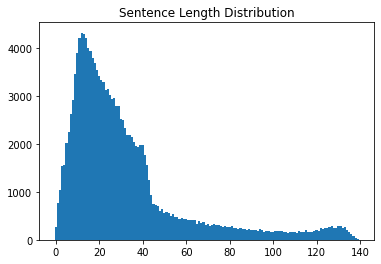

In [45]:
# 데이터 길이 분포 확인하기
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    # 전체 문장을 합치면 길이가 얼마나 될까요?
    sum_len += length

print("문장의 최단 길이는", min_len, '입니다.')
print("문장의 최장 길이는", max_len, '입니다.')
print("문장의 평균 길이는", sum_len // len(train_data), '입니다.')

# 전체 길이만큼 0벡터 ==> 길이에 따른 문장의 수를 저장하기 위해 먼저 0으로 이루어진 리스트를 만든다!!
sentence_length = np.zeros((max_len), dtype=np.int)
print("sentence_length : ",sentence_length)

# raw는 위에서 다운로드한 데이터셋!! 전체 길이와 상관없음
for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1 # 0으로 이루어진 벡터에 문장 count를 더한 뒤 넣는다.

plt.bar(range(max_len), sentence_length, width=1.0) # 너비는 1.0씩 늘어나도록 설정
plt.title("Sentence Length Distribution")
plt.show()

아까 Step 0에서 최대 최소 길이를 제한해서 길이 분포를 다시 그렸었죠?

다양한 해결 방법을 사용하기 위해서, 프로젝트에서는 다른 방법을 사용하겠습니다.

분포상에서 보았을 때, 대충 **길이가 45 정도인 데이터까지 취급하면 괜찮을 것 같습니다!**

In [46]:
## 학습 데이터, 테스트 데이터 모두 각각 길이가 45 이하인 데이터까지만 취급합니다.
## 아래 과정은 document의 내용만을 list로 전달하기 때문에 SentencePiece 모델을 적용할 때 용이합니다.
train_list = [s for s in train_data['document'] if (len(s) <= 45)]
test_list = [s for s in test_data['document'] if (len(s) <= 45)]

train_list = list(set(train_list))
test_list = list(set(test_list))

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

**pd.merge()** 함수를 활용해 길이가 45 이하인 학습 데이터와 테스트 데이터를 기존의 데이터와 병합시킵니다.

In [47]:
new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

길이가 45 이하인 데이터로 제한한 후 살아남은 데이터를 확인해 보겠습니다.

In [48]:
display(train_data.head())
display(test_data.head())

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0


,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,7898805,음악이 주가 된 최고의 음악영화,1


수치적으로 얼마나 살아남았을까요?

In [49]:
print("살아남은 학습 데이터는",len(train_data), '개 입니다.')
print("살아남은 테스트 데이터는",len(test_data), '개 입니다.')

살아남은 학습 데이터는 118437 개 입니다.
살아남은 테스트 데이터는 39821 개 입니다.


최소, 최대 길이까지 제한해서 처리하고 나니 처음보다 확실히 데이터가 적절히 축소되었음을 확인할 수 있습니다!

이제, 이전에 Step 3에서 정의했던 **sp.tokenize()** 를 사용해서 학습 데이터와 테스트 데이터를 토큰화해 보겠습니다.

In [50]:
## 학습 데이터, 테스트 데이터 토큰화
X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test, X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])
## label 값을 y_train, y_test로 처리
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

토큰화가 잘 되었는지 확인해 봅시다.

In [51]:
print(X_train[:2])

[[ 142  106 2615  909 4849    4 4849  757   69  555  520 2648    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   4 7662  474 1750  154   14  447 3174 2765 1788  176  412  383   41
  4183    4   11 7568   29 1313  231   69    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]


In [52]:
print(X_test[:2])

[[   4 7888    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   4 7826  169   25 1092  347  108  196 5570  167 4281  644    4 3359
    10  106  378 7638 2502    0   98    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [53]:
print(y_train[:2])

[0 1]


In [54]:
print(y_test[:2])

[1 0]


넷 다 정상적으로 정수로 잘 토큰화가 되었습니다! 😊😊

토큰화를 완료한 후의 학습 데이터의 개수와 label의 개수를 살펴봅니다.

In [55]:
print("토큰화 후 학습 데이터의 수는",len(X_train), '개 입니다.')
print("토큰화 후 학습 데이터의 라벨 수는",len(y_train), '개 입니다.')

토큰화 후 학습 데이터의 수는 118437 개 입니다.
토큰화 후 학습 데이터의 라벨 수는 118437 개 입니다.


한편, **사이킷런(scikit-learn)에서는 학습 데이터와 검증 데이터를 분리하기 위해 train_test_split를 사용합니다.**

In [56]:
from sklearn.model_selection import train_test_split

일반적으로 **학습 데이터와 검증 데이터는 8:2로 나누는 경우가 많습니다.** 본 프로젝트에서도 8:2로 나누도록 하겠습니다.

즉, test_size는 전체 1.0 값 중에 0.2를 차지하게 되겠죠? 😉😉

In [57]:
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

그렇다면, **random_state**는 무엇을 나타낼까요? 아래 링크를 통해 'random_state = n'의 의미를 이해해 봅시다!

**링크 1 : https://kin.naver.com/qna/detail.naver?d1id=1&dirId=104&docId=384587116&qb=cmFuZG9tX3N0YXRl&enc=utf8&section=kin.ext&rank=1&search_sort=0&spq=0**

**링크 2 : https://blog.naver.com/leehj9012/222442501175**

**정리해 보면 다음과 같습니다.**

- random_state의 값은 어떠한 값으로 해도 상관이 없습니다.
- random_state를 쓰지 않으면 매번 컴파일을 할 때마다 학습 데이터셋과 검증 데이터셋이 바뀝니다.
- random_state에 아무 숫자나 넣어주면 매번 컴파일을 할 때마다 학습 데이터셋과 검증 데이터셋이 바뀌지 않습니다.

train_test_split를 통해 나누어진 결과를 확인해 보겠습니다.

In [58]:
print(train_input[:2])

[[2009   24  812    7 1001 2295  379  113  199  265   10 2760    8   14
   218 1526    6 3582  128  222  620  521    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1574  114  180  299  136   10 5637 1642    8  116  299  136 7997   38
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]


In [59]:
print(val_input[:2])

[[  59 7533    6 4450  152  167  223 1300    9    4 5439 3941  303  230
     4 1351 7026 1473    4 1417 1797   31 1564 2539    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   4    0   97  128  119 1330  299    0   73    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]


In [60]:
print(train_target[:2])

[1 0]


In [61]:
print(val_target[:2])

[0 1]


### 4. 모델 학습 및 평가

이제, 앞서 만든 SentencePiece 모델을 활용하여 모델 학습을 해보겠습니다.

In [62]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
# 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Oct  3 13:30 korean_spm.model
-rw-r--r-- 1 root root 146388 Oct  3 13:30 korean_spm.vocab


In [63]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [64]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

Exploration 7에서 언급했던 3가지 모델 중에서 LSTM의 정확도가 가장 높게 나왔었습니다.

이에 먼저 **LSTM 모델을 설계하고 학습시키겠습니다.**

In [65]:
## 순환신경망 모델 선언 (1번째 LSTM 모델)
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 45  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 45)          360000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1728      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 361,809
Trainable params: 361,809
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
2961/2961 [==============================] - 32s 10ms/step - loss: 0.6272 - accuracy: 0.6504 - val_loss: 0.6116 - val_accuracy: 0.6383
Epoch 2/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.6569 - accuracy: 0.5674 - val_loss: 0.5771 - val_accuracy: 0.7255
Epoch 3/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5965 - accuracy: 0.6771 - val_loss: 0.5734 - val_accuracy: 0.7327
Epoch 4/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5628 - accuracy: 0.7458 - val_loss: 0.5661 - val_accuracy: 0.7448
Epoch 5/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5553 - accuracy: 0.7454 - val_loss: 0.6477 - val_accuracy: 0.5756
Epoch 6/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.6344 - accuracy: 0.5992 - val_loss: 0.5879 - val_accuracy: 0.6944
Epoch 7/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5644 - accuracy: 0.7204 - val_loss: 0.5663 -

**학습 결과를 확인합니다!**

- LSTM 첫 번째 accuracy : **77%**
- vocab_size = 8000, word_vector_dim = 45인 임베딩 층 구성, LSTM(8), Dense(8, relu), Dense(1, sigmoid)

In [67]:
lstm_result = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result)

1245/1245 - 5s - loss: 0.5040 - accuracy: 0.7700
[0.503966748714447, 0.7699957489967346]


루브릭에 따라 accuracy 값을 80% 이상으로 올리기 위해 여러 파라미터들을 조정해서 학습시켜 보겠습니다! 🧡

**💙2번째 LSTM 모델💙**
- 1번째 LSTM 모델에서 vocab_size만 늘렸습니다.
- 해당 모델의 accuracy : 75.2%

In [68]:
## 순환신경망 모델 선언 (2번째 LSTM 모델)
vocab_size = 9000    # 어휘 사전의 크기
word_vector_dim = 45  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 45)          405000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1728      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 406,809
Trainable params: 406,809
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
2961/2961 [==============================] - 32s 10ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.4969
Epoch 2/10
2961/2961 [==============================] - 30s 10ms/step - loss: 0.6745 - accuracy: 0.5379 - val_loss: 0.6002 - val_accuracy: 0.6939
Epoch 3/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5867 - accuracy: 0.7154 - val_loss: 0.5771 - val_accuracy: 0.7360
Epoch 4/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5766 - accuracy: 0.7233 - val_loss: 0.5867 - val_accuracy: 0.7084
Epoch 5/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5699 - accuracy: 0.7361 - val_loss: 0.5778 - val_accuracy: 0.7349
Epoch 6/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5774 - accuracy: 0.7239 - val_loss: 0.5748 - val_accuracy: 0.7373
Epoch 7/10
2961/2961 [==============================] - 29s 10ms/step - loss: 0.5697 - accuracy: 0.7413 - val_loss: 0.5878 -

In [70]:
lstm_result2 = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result2)

1245/1245 - 5s - loss: 0.5372 - accuracy: 0.7520
[0.537214994430542, 0.7520152926445007]


**💙3번째 LSTM 모델💙**
- 1번째 LSTM 모델에서 word_vector_dim만 줄였습니다.
- 해당 모델에서 accuracy가 처음으로 80%를 넘겼습니다! (**82.1%**)

In [73]:
## 순환신경망 모델 선언 (2번째 LSTM 모델)
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 30  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 30)          240000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1248      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 241,329
Trainable params: 241,329
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
2961/2961 [==============================] - 30s 9ms/step - loss: 0.6082 - accuracy: 0.6604 - val_loss: 0.4415 - val_accuracy: 0.7942
Epoch 2/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.4154 - accuracy: 0.8088 - val_loss: 0.4059 - val_accuracy: 0.8152
Epoch 3/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.3631 - accuracy: 0.8376 - val_loss: 0.4068 - val_accuracy: 0.8171
Epoch 4/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.3396 - accuracy: 0.8484 - val_loss: 0.4139 - val_accuracy: 0.8182
Epoch 5/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.3192 - accuracy: 0.8596 - val_loss: 0.4005 - val_accuracy: 0.8210
Epoch 6/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.2982 - accuracy: 0.8715 - val_loss: 0.4030 - val_accuracy: 0.8255
Epoch 7/10
2961/2961 [==============================] - 28s 9ms/step - loss: 0.2785 - accuracy: 0.8820 - val_loss: 0.4092 - val_ac

In [75]:
lstm_result3 = model.evaluate(X_test, y_test, verbose=2)
print(lstm_result3)

1245/1245 - 5s - loss: 0.4442 - accuracy: 0.8210
[0.4441627264022827, 0.8210492134094238]


## 프로젝트 회고

Exploration 7 프로젝트에서 사용했던 세 가지 모델 중 가장 좋은 accuracy를 보였던 **LSTM 모델을 사용**하여 vocab_size와 word_vector_dim을 수정해 나가며 accuracy를 루브릭 수준으로 끌어올릴 수 있었습니다.

학습을 진행한 결과, **단어 벡터의 차원 수를 줄이는 것이 단어장의 크기를 늘리는 것보다 accuracy가 높았음**을 확인하였습니다.

네이버 영화리뷰 감성분석 Task를 활용해 다른 모델에 실제로 적용해야 했던 프로젝트여서 생각보다 많이 어렵게 느끼지 않았나 생각합니다.

## 루브릭 확인

|루브릭 평가항목|세부기준|
|------|---|
|SentencePiece를 이용하여 모델을 만드는 과정이 성공적으로 전개|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작 등이 잘 수행되었음|
|SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하며, 80% 이상의 test accuracy 확인|
|SentencePiece의 성능에 대한 비교분석|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저나, SentencePiece의 다른 옵션의 경우와 비교하여 분석|

## 자가 평가

**루브릭 1** : 모델 학습과 accuracy를 도출하기 위해 SentencePiece를 이용하여 모델을 구현하였으며, 과정이 정상적으로 진행되었습니다.

**루브릭 2** : SentencePiece와 비슷한 동작을 수행하는 sp_tokenize() 함수를 구현하여 이를 자연어처리 모델인 LSTM에 적용했으며, 3번의 시도를 통해 82.1%의 accuracy를 얻었습니다.

**루브릭 3** : 이거는.. 저도 만족했다고 할 수 있을지 잘은 모르겠습니다 ㅠㅠ